# Bayesian Optimization

In [12]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
from skgarden import RandomForestQuantileRegressor
from dependence.plots import set_style_paper
from skopt import forest_minimize
from skopt.acquisition import gaussian_ei

%matplotlib inline
%load_ext autoreload
%autoreload 2
set_style_paper()

## The stochastic function

In [13]:
from scipy.special import erfinv
def func(X, noise_lvl=0.2, nu=1., return_quantile=False, type_noise='uniform', alpha=0.05):
    """
    """
    X = np.asarray(X)
    n_sample = X.shape[0]
    if type_noise == 'uniform':
        noise = np.random.uniform(-noise_lvl, noise_lvl, n_sample)
    elif type_noise == 'normal':
        noise = np.random.normal(0., noise_lvl, n_sample)
    else:
        raise ValueError('Wrong type_noise')
        
    y = X*np.cos(2*np.pi*X) + (X-nu)**2*noise
    if return_quantile:
        if type_noise == 'uniform':
            q = 2*noise_lvl*alpha - noise_lvl
        elif type_noise == 'normal':
            q = noise_lvl*np.sqrt(2)*erfinv * (2*alpha - 1)
            
        quantile = X*np.cos(2*np.pi*X) + (X-nu)**2*q 
        if n_sample == 1:
            return y.item(), quantile.item()
        else:
            return y, quantile
    else:
        if n_sample == 1:
            return y.item()
        else:
            return y

### Illustration

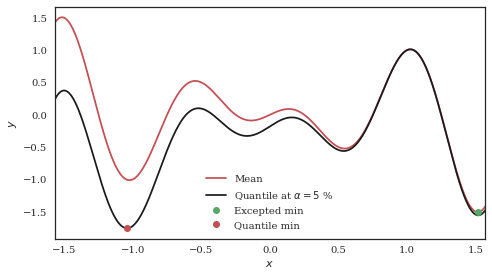

In [14]:
xmin, xmax = -np.pi/2, np.pi/2.

def plot_func(func, xmin, xmax, n_plot=100000, alpha=0.05, ax=None):
    x_plot = np.linspace(xmin, xmax, n_plot)
    y_true = func(x_plot, noise_lvl=0.)
    y_noised, quant = func(x_plot, return_quantile=True, alpha=alpha)
    id_min_true = y_true.argmin()
    id_min_noised = quant.argmin()

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(x_plot, y_true, 'r-', label='Mean')
    ax.plot(x_plot, quant, 'k-', label='Quantile at $\\alpha=%d$ %%' % (alpha*100))
    ax.plot(x_plot[id_min_true], y_true[id_min_true], 'go', label='Excepted min')
    ax.plot(x_plot[id_min_noised], quant[id_min_noised], 'ro', label='Quantile min')
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('$x$')    
    ax.set_ylabel('$y$')
    return ax

fig, ax = plt.subplots(figsize=(7, 4))
plot_func(func, xmin, xmax, ax=ax)
ax.legend(loc=0)
fig.tight_layout()

## Optimization

In [ ]:
class ModifiedRandomForestQuantileRegressor(RandomForestQuantileRegressor):
    def predict(self, X, return_std=False):
        """
        """
        X = np.asarray(X)
        alpha = 0.05
        n_sample = X.shape[0]
        n_estimators = self.n_estimators
        pred = np.zeros((n_estimators, n_sample))
        for i, tree in enumerate(self.estimators_):
            pred[i] = tree.predict(X, quantile=alpha*100)
            
        mean = pred.mean(axis=0)
        if return_std:
            std = pred.std(axis=0)
            return mean, std
        else:
            return mean

In [ ]:
n_random_start = 100
n_iter = 50
n_estimators = 100
min_samples_split = max(2, int(n_random_start/10))
rfq = ModifiedRandomForestQuantileRegressor(n_estimators, min_samples_split=min_samples_split, n_jobs=7)
n_calls = n_random_start + n_iter
space = [(xmin, xmax)]
acq_func = 'EI'

opt_res = forest_minimize(func, space, acq_func=acq_func, base_estimator=rfq,
                      n_calls=n_calls, n_random_starts=n_random_start, n_jobs=7, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0014
Function value obtained: -0.0188
Current minimum: -0.0188
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: 0.2172
Current minimum: -0.0188
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: 0.8781
Current minimum: -0.0188
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: -1.4683
Current minimum: -1.4683
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0004
Function value obtained: -0.7020
Current minimum: -1.4683
Iteration No: 6 started. Ev

Iteration No: 98 started. Evaluating function at random point.
Iteration No: 98 ended. Evaluation done at random point.
Time taken: 0.0003
Function value obtained: 0.1265
Current minimum: -1.7224
Iteration No: 99 started. Evaluating function at random point.
Iteration No: 99 ended. Evaluation done at random point.
Time taken: 0.0003
Function value obtained: 0.1820
Current minimum: -1.7224
Iteration No: 100 started. Evaluating function at random point.
Iteration No: 100 ended. Evaluation done at random point.
Time taken: 0.6931
Function value obtained: 0.8044
Current minimum: -1.7224
Iteration No: 101 started. Searching for the next optimal point.
Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 0.6865
Function value obtained: 0.0858
Current minimum: -1.7224
Iteration No: 102 started. Searching for the next optimal point.
Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 0.6962
Function value obtained: -0.7090
Current minimu

### Results

In [ ]:
model = opt_res.models[-1]
x = np.asarray(opt_res.x_iters)
q = model.predict(x)
x_random_start = x[:n_random_start]
x_iter = x[n_random_start:]
y_random_start = q[:n_random_start]
y_iter = q[n_random_start:]
id_min = q.argmin()
x_min = x[id_min]
q_min = q[id_min]
acq = gaussian_ei(x, model, y_opt=np.min(q))

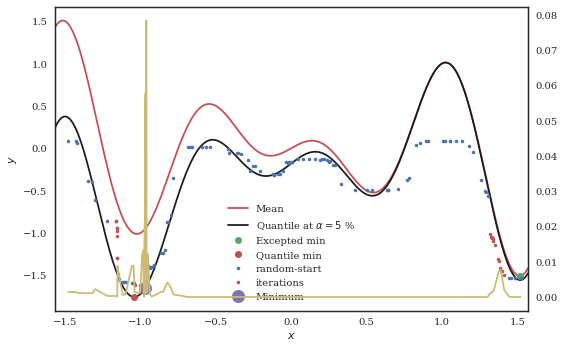

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

plot_func(func, xmin, xmax, ax=ax)
id_sort = np.argsort(x, 0).ravel()
ax2 = ax.twinx()
ax2.plot(x[id_sort], acq[id_sort], "y", label="EI(x)")
ax.plot(x_random_start, y_random_start, 'b.', label='random-start')
ax.plot(x_iter, y_iter, 'r.', label='iterations')
ax.plot(x_min, q_min, 'mo', markersize=13, label='Minimum')
ax.legend(loc=0)
fig.tight_layout()
#fig.savefig('bayesian-optim-test.pdf')

In [1]:


import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image

In [3]:


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

In [11]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    print(i)
    return (line,)

# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [5]:
anim.save('animation.gif', writer='imagemagick', fps=60)